In [1]:
"""
Yontem - 1
Feature extraction using SIFT and Bag of Visual Words (BOVW) model
Feature extraction is done by SIFT.
Bag of Visual Words (BOVW) model is used to represent images as histograms of visual words.
Extracted features are then used to train a Support Vector Machine (SVM) model for image classification.
"""


# Imports
import cv2
import numpy as np
import os
import random
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
# Functions
def extract_features(image_paths, extractor):
    features = []
    for path in image_paths:
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = extractor.detectAndCompute(gray, None)
        if descriptors is not None:
            features.append(descriptors)
    return np.concatenate(features, axis=0)

def create_bovw_histograms(image_paths, extractor, kmeans):
    histograms = []
    for path in image_paths:
        image = cv2.imread(path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = extractor.detectAndCompute(gray, None)
        histogram = np.zeros(len(kmeans.cluster_centers_))  # Initialize histogram for each image
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                histogram[label] += 1
        histograms.append(histogram)  # Append histogram regardless of descriptor availability
    return np.array(histograms)

def load_dataset(root_dir): # takes the folder name (class name) as label
    image_paths = []
    labels = []
    label_to_id = {}
    for idx, class_name in enumerate(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            label_to_id[class_name] = idx
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                image_paths.append(file_path)
                labels.append(idx)
    return image_paths, labels, label_to_id

def model_evaluation(X, y, y_pred):
    # Match Accuracy
    match_accuracy = np.mean(y_pred == y) #accuracy_score(y, y_pred)
    print('Match Accuracy:', match_accuracy)

    # Matching Precision and Recall
    precision = precision_score(y, y_pred, average='macro')
    print('Precision:', precision)
    recall = recall_score(y, y_pred, average='macro')
    print('Recall:', recall)

    # Feature Count
    feature_count = X.shape[1]
    print('Feature Count:', feature_count)

    # Unique Match Ratio
    unique_match_ratio = len(np.unique(y_pred)) / len(np.unique(y))
    print('Unique Match Ratio:', unique_match_ratio)

    # Precision-Recall Curve
    #precision_curve, recall_curve, _ = precision_recall_curve(y, y_pred)

    return {
        'Match Accuracy': match_accuracy,
        'Precision': precision,
        'Recall': recall,
        'Feature Count': feature_count,
        'Unique Match Ratio': unique_match_ratio
        #'Precision-Recall Curve': (precision_curve, recall_curve)
    }

def display_all_results(image_paths, predicted_labels, true_labels, label_to_id):
    id_to_label = {v: k for k, v in label_to_id.items()}
    num_images = len(image_paths)
    num_cols = 4
    num_rows = num_images // num_cols + (1 if num_images % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for idx, path in enumerate(image_paths):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        pred_label = id_to_label.get(predicted_labels[idx], "Unknown")
        true_label = id_to_label.get(true_labels[idx], "Unknown")
        result = "TRUE" if predicted_labels[idx] == true_labels[idx] else "FALSE"
        ax.set_title(f"Predicted: {pred_label}, True: {true_label}\n{result}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def display_sample_results(image_paths, predicted_labels, true_labels, label_to_id, sample_size=10):
    id_to_label = {v: k for k, v in label_to_id.items()}
    # Ensure sample_size is not larger than the dataset size
    sample_size = min(sample_size, len(image_paths))
    
    # Randomly sample indices without replacement
    sampled_indices = random.sample(range(len(image_paths)), sample_size)
    
    # Subset the data
    sampled_image_paths = [image_paths[i] for i in sampled_indices]
    sampled_predicted_labels = [predicted_labels[i] for i in sampled_indices]
    sampled_true_labels = [true_labels[i] for i in sampled_indices]
    
    # Calculate the layout for the subplot
    num_cols = 4
    num_rows = sample_size // num_cols + (1 if sample_size % num_cols != 0 else 0)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)
    axes = axes.flatten()
    
    for idx, path in enumerate(sampled_image_paths):
        ax = axes[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        pred_label = id_to_label.get(sampled_predicted_labels[idx], "Unknown")
        true_label = id_to_label.get(sampled_true_labels[idx], "Unknown")
        result = "TRUE" if sampled_predicted_labels[idx] == sampled_true_labels[idx] else "FALSE"
        ax.set_title(f"Predicted: {pred_label}, True: {true_label}\n{result}")
        ax.axis('off')
    
    # Hide any unused subplot areas
    for idx in range(len(sampled_image_paths), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
# Parameters
num_clusters = 100
root_dir_train = 'small_64x64/train'
root_dir_test = 'small_64x64/test'
root_dir_val = 'small_64x64/validation'

# Load datasets
image_paths_train, labels_train, label_to_id_train = load_dataset(root_dir_train)
image_paths_test, labels_test, label_to_id_test = load_dataset(root_dir_test)
image_paths_val, labels_val, label_to_id_val = load_dataset(root_dir_val)

In [ ]:
"""import cv2
import numpy as np

# Your image
image = cv2.imread('your_image.jpg', 0)  # Read in grayscale

# Define ranges for parameters you want to optimize
nfeatures_range = [0, 50, 100, 200]
nOctaveLayers_range = [3, 4, 5]
contrastThreshold_range = [0.04, 0.1, 0.2]
edgeThreshold_range = [10, 15, 20]
sigma_range = [1.2, 1.6, 2.0]

# Placeholder for best settings and score
best_score = 0
best_settings = {}

# Brute-force search
for nfeatures in nfeatures_range:
    for nOctaveLayers in nOctaveLayers_range:
        for contrastThreshold in contrastThreshold_range:
            for edgeThreshold in edgeThreshold_range:
                for sigma in sigma_range:
                    # Create SIFT with current settings
                    sift = cv2.SIFT_create(nfeatures=nfeatures, nOctaveLayers=nOctaveLayers,
                                           contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold,
                                           sigma=sigma)
                    
                    # Detect features
                    keypoints = sift.detect(image, None)

                    # Here you should define how you measure the 'goodness' of the detected features for your task.
                    # For simplicity, I'm just using the number of detected keypoints as the score.
                    score = len(keypoints)

                    # Update best score and settings if current score is better
                    if score > best_score:
                        best_score = score
                        best_settings = {
                            'nfeatures': nfeatures,
                            'nOctaveLayers': nOctaveLayers,
                            'contrastThreshold': contrastThreshold,
                            'edgeThreshold': edgeThreshold,
                            'sigma': sigma
                        }

# Print best settings
print("Best score:", best_score)
print("Best settings:", best_settings)
"""

In [4]:
# SIFT feature extractor and KMeans clustering model creation
sift = cv2.SIFT_create()
features_train = extract_features(image_paths_train, sift)
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(features_train)

KMeans(n_clusters=100)

In [5]:
# Create BOVW histograms for train, test, and validation sets
bovw_histograms_train = create_bovw_histograms(image_paths_train, sift, kmeans)
bovw_histograms_test = create_bovw_histograms(image_paths_test, sift, kmeans)
bovw_histograms_val = create_bovw_histograms(image_paths_val, sift, kmeans)

# Train, test, and validation data split
X_train, y_train = bovw_histograms_train, labels_train
X_test, y_test = bovw_histograms_test, labels_test
X_val, y_val = bovw_histograms_val, labels_val

In [6]:
"""# Model creation and training
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X_train, y_train)"""

'# Model creation and training\nclf = make_pipeline(StandardScaler(), SVC())\nclf.fit(X_train, y_train)'

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],  # Kernel type
    'svc__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Create a pipeline with StandardScaler and SVM
pipeline = make_pipeline(StandardScaler(), SVC())

# Instantiate the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Best parameters found during grid search
print("Best Parameters:", grid_search.best_params_)

# Best cross-validation accuracy
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

# Evaluate the best model on the test set
print("Model Evaluation on Test Set after Hyperparameter Tuning")
test_evaluation_after_tuning = model_evaluation(X_test, y_test, y_pred_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


Model Evaluation on Test Set
Match Accuracy: 0.2530487804878049
Precision: 0.2627922393221041
Recall: 0.2530487804878049
Feature Count: 100
Unique Match Ratio: 1.0


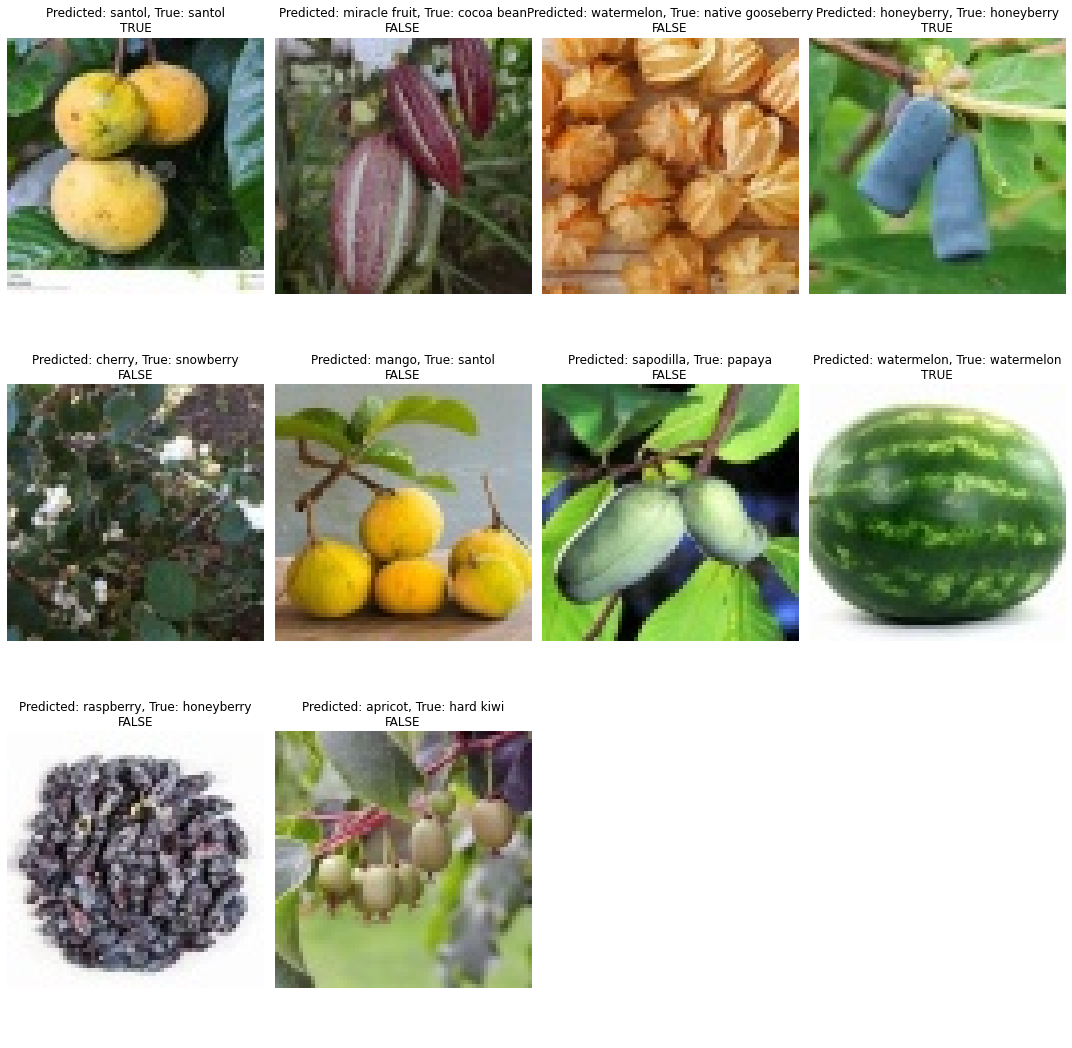

Model Evaluation on Validation Set
Match Accuracy: 0.26097560975609757
Precision: 0.27694342238172825
Recall: 0.2609756097560975
Feature Count: 100
Unique Match Ratio: 1.0


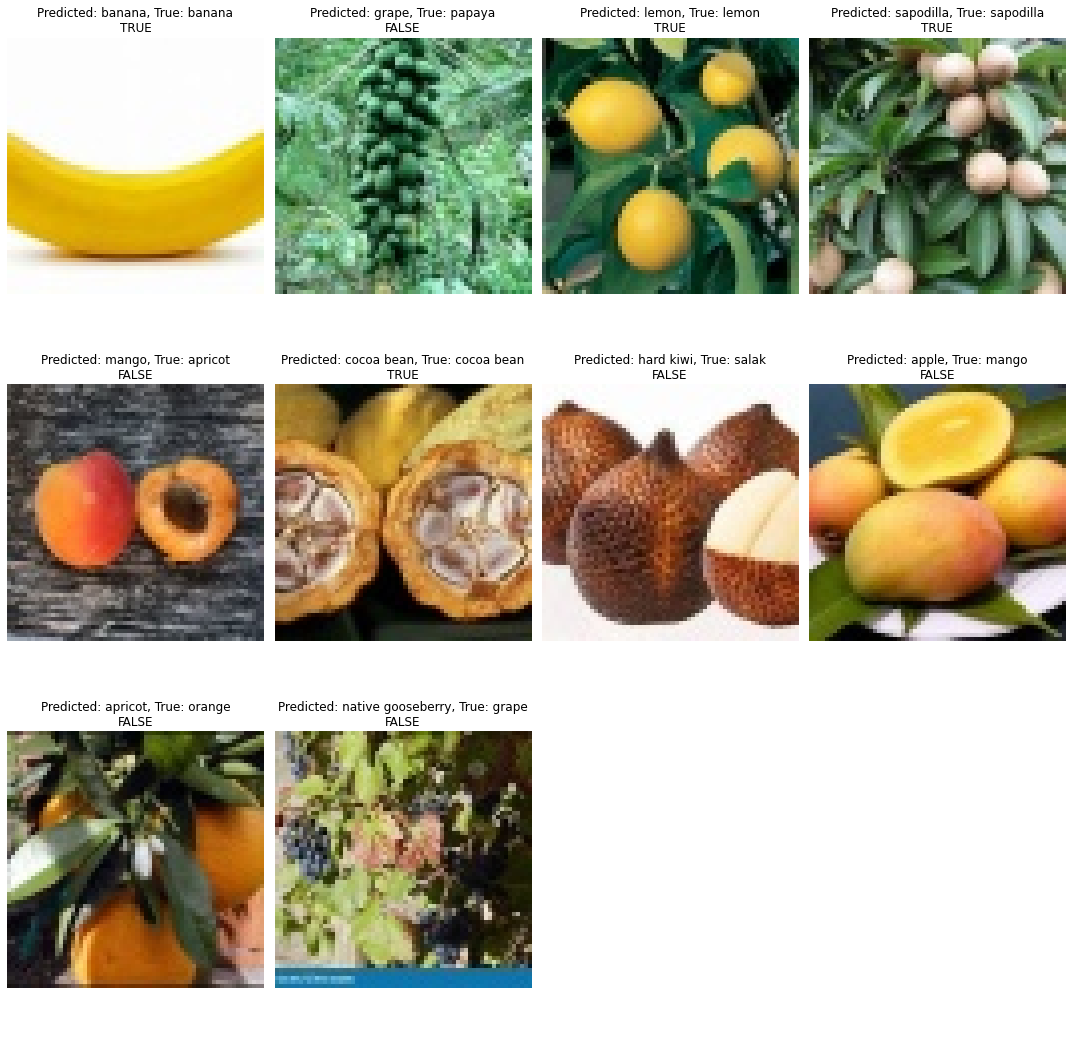

In [ ]:
"""# Model evaluation on test set
y_pred = clf.predict(X_test)
print("Model Evaluation on Test Set")
test_evaluation = model_evaluation(X_test, y_test, y_pred)

# Display results for the test set
#display_all_results(image_paths_test, y_pred, y_test, label_to_id_test)
display_sample_results(image_paths_test, y_pred, y_test, label_to_id_test)


# Model evaluation on validation set
y_pred_val = clf.predict(X_val)
print("Model Evaluation on Validation Set")
validation_evaluation = model_evaluation(X_val, y_val, y_pred_val)

# Display results for the validation set
#display_all_results(image_paths_val, y_pred_val, y_val, label_to_id_val)
display_sample_results(image_paths_val, y_pred_val, y_val, label_to_id_val)"""

In [ ]:
"""precision-recall curve for each class code
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

# Convert labels to binary format
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(np.unique(y_val))):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_pred_val[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], y_pred_val[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_val))):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()
"""

'precision-recall curve for each class code\nfrom sklearn.metrics import precision_recall_curve\nfrom sklearn.preprocessing import label_binarize\nfrom sklearn.metrics import average_precision_score\n\n# Convert labels to binary format\ny_val_bin = label_binarize(y_val, classes=np.unique(y_val))\n\n# Compute precision and recall for each class\nprecision = dict()\nrecall = dict()\naverage_precision = dict()\nfor i in range(len(np.unique(y_val))):\n    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_pred_val[:, i])\n    average_precision[i] = average_precision_score(y_val_bin[:, i], y_pred_val[:, i])\n\n# Plot precision-recall curve for each class\nplt.figure(figsize=(8, 6))\nfor i in range(len(np.unique(y_val))):\n    plt.plot(recall[i], precision[i], lw=2, label=\'Class {}\'.format(i))\n\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve\')\nplt.legend(loc="best")\nplt.show()\n'